<a href="https://colab.research.google.com/github/jeryjayjae/daiz/blob/main/emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Colab 환경 설정

####실행에 필요한 라이브러리와 KoBERT 모델을 불러온다

In [ ]:
# 1. 코랩 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

#Kobert 파일 로드 from github
!pip install git+https://github.com/Jsgithubchannel/KoBERT.git@master

#토큰화
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/Jsgithubchannel/KoBERT.git (to revision master) to /tmp/pip-req-build-i_6mg455
  Running command git clone -q https://github.com/Jsgithubchannel/KoBERT.git /tmp/pip-req-build-i_6mg455
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-hqw1j04p/kobert-tokenizer_a0ace5a40a854dc49b70935b735904f9
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-hqw1j04p/kobert-tokenizer_a0ace5a40a854dc49b70935b735904f9


####필요한 모듈을 import

In [ ]:
# 환경 설정 (필요한 모듈 import)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm import tqdm, notebook

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

####구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/capstone_design/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/capstone_design


# 2. 데이터셋 전처리

####구글 드라이브에서 데이터 파일 읽어오기


In [ ]:
test_data = pd.read_excel('감성대화말뭉치(최종데이터)_Training.xlsx')
test_data2 = pd.read_excel('한국어_연속적_대화_데이터셋2.xlsx')

KeyboardInterrupt: ignored

####전처리를 위해 감정에 숫자 할당

In [ ]:
# 전처리 수행
emotions = ['기쁨','당황','분노','불안','상처','슬픔', '중립'] # 감정 대분류
for i in range(len(emotions)):
  test_data.loc[(test_data['감정_대분류'] == emotions[i]), '감정_대분류'] = i
  test_data2.loc[(test_data2['감정'] == emotions[i]), '감정'] = i

#### test_data 파일에서 사람문장1~사람문장4를 합치고 data_list에 넣음

In [ ]:
# test_data
nullcheck1 = test_data['사람문장1'].isnull()
nullcheck2 = test_data['사람문장2'].isnull()
nullcheck3 = test_data['사람문장3'].isnull()
nullcheck4 = test_data['사람문장4'].isnull()

data_list= []

for check1,check2, check3, check4, label, sentence1, sentence2, sentence3, sentence4 in zip(nullcheck1,nullcheck2, nullcheck3, nullcheck4, test_data['감정_대분류'], test_data['사람문장1'], test_data['사람문장2'], test_data['사람문장3'], test_data['사람문장4'])  :
    data = []
    sentence = ""

    if check1 != True :
      sentence = sentence1

    if check2 != True :
      sentence = sentence + " " + str(sentence2)

    if check3 != True :
      sentence = sentence + " " + sentence3

    if check4 != True :
      sentence = sentence + " " + sentence4
    
    
    data.append(sentence)
    data.append(str(label))

    data_list.append(data)

####test_data2에서 각 문장을 data_list에 넣음

In [ ]:
# test_data2
nullcheck = test_data2['발화'].isnull()
nullcheck1 = test_data2['감정'].isnull()

for sen, emo, check, check1 in zip(test_data2["발화"], test_data2["감정"], nullcheck,nullcheck1) :
  data = []
  data.append(sen)
  data.append(str(emo))
  if check != True :
      if check1 !=True :
        data_list.append(data)

####전처리한 데이터(data_list)를 학습 데이터와 데스트 데이터로 나눔

In [ ]:
# 3. Train data & Test data
from sklearn.model_selection import train_test_split
                                                         
#dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)
dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, random_state=0)

####KoBERT 모델에 들어가기 위해 입력 데이터로 만들기

In [ ]:
# 4. KoBERT 입력 데이터로 만들기

# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

####각 인자들 세팅

In [ ]:
# # Setting parameters
max_len = 200
batch_size = 16
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate =  4e-5      

####토큰화

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = get_tokenizer()
bertmodel, vocab = get_pytorch_kobert_model()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model
using cached model
using cached model


In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

####torch 형식의 dataset 만들기

In [ ]:
# torch 형식의 dataset
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

# 3. KoBERT 학습모델 만들기

####분류 클래스 만들기

In [ ]:
# 5. KoBERT 학습모델 만들기
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

####cuda 사용

In [ ]:
device = torch.device("cuda:0")

####BERT 모델 불러오고, optimizer와 스케쥴 설정, 정확도 측정 함수 작성

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate) # optimizer: 모델을 학습 할 때 데이터의 실제 결과와 모델이 예측한 결과를 기반으로 잘 줄일 수 있게 만들어주는 역할, 현재 가장 많이 사용하는 옵티마이저는 Adam
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

# 4. KoBERT 모델 학습

####EarlyStopping 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

####Early Stopping 사용한 모델 학습 함수

In [ ]:
def train_model(model, batch_size, patience, num_epochs):
  # 6. KoBERT 모델 학습시키기

  train_losses = [] # 모델이 학습되는 동안 trainning loss를 track
  valid_losses = [] # 모델이 학습되는 동안 validation loss를 track
  avg_train_losses = [] # epoch당 average training loss를 track
  avg_valid_losses = [] # epoch당 average validation loss를 track

  # early_stopping object의 초기화
  early_stopping = EarlyStopping(patience = patience, verbose = True)

  for epoch in range(1, num_epochs + 1):
    train_acc = 0.0
    test_acc = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
      optimizer.zero_grad() # clear the gradients of all optimized variables

      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)
      valid_length= valid_length
      label = label.long().to(device)

      out = model(token_ids, valid_length, segment_ids) # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
      
      loss = loss_fn(out, label) # loss 계산
      loss.backward() # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      optimizer.step() # perform a single optimization step (parameter update)
      scheduler.step()  # Update learning rate schedule
      train_acc += calc_accuracy(out, label)
      if batch_id % log_interval == 0:
        print("epoch {} batch id {} loss {} train acc {}".format(epoch, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
      train_losses.append(loss.item()) # train loss 기록


      
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)
      valid_length= valid_length
      label = label.long().to(device)

      out = model(token_ids, valid_length, segment_ids) # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
      test_acc += calc_accuracy(out, label)
      loss = loss_fn(out, label) # loss 계산
      valid_losses.append(loss.item()) # vaildation loss 기록
    print("epoch {} test acc {}".format(epoch, test_acc / (batch_id+1)))
      
    # print 학습/검증 statistics
    # epoch당 평균 loss 계산
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(num_epochs))
    print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                      f'train_loss: {train_loss:.5f} ' +
                      f'valid_loss: {valid_loss:.5f}')
    print(print_msg)

    # 다음 에폭 track하기 위해 리스트 초기화
    train_losses = []
    valid_losses = []

    # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
    # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
      print("Early stopping")
      break

  # best model이 저장되어있는 last checkpoint를 로드한다.
  model.load_state_dict(torch.load('checkpoint.pt'))

  return  model, avg_train_losses, avg_valid_losses

#### CUDA out of memory 발생시 실행

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

####모델 학습

In [ ]:
# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, num_epochs)   

  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.099395513534546 train acc 0.1875
epoch 1 batch id 201 loss 2.0677714347839355 train acc 0.11100746268656717
epoch 1 batch id 401 loss 1.9315180778503418 train acc 0.12468827930174564
epoch 1 batch id 601 loss 1.839059591293335 train acc 0.15536605657237937
epoch 1 batch id 801 loss 1.8213438987731934 train acc 0.20895755305867666
epoch 1 batch id 1001 loss 1.4134491682052612 train acc 0.26117632367632365
epoch 1 batch id 1201 loss 1.3952593803405762 train acc 0.2981890091590341
epoch 1 batch id 1401 loss 1.2129238843917847 train acc 0.3274446823697359
epoch 1 batch id 1601 loss 1.6903070211410522 train acc 0.3488835103060587
epoch 1 batch id 1801 loss 1.7452976703643799 train acc 0.3673306496390894
epoch 1 batch id 2001 loss 1.2599589824676514 train acc 0.38427661169415295
epoch 1 batch id 2201 loss 1.3469547033309937 train acc 0.3968934575193094
epoch 1 batch id 2401 loss 1.3592264652252197 train acc 0.41094856309870886
epoch 1 batch id 2601 loss 1.0691478252

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 1 test acc 0.7494440675410825
[  1/100] train_loss: 1.24496 valid_loss: 0.78672
Validation loss decreased (inf --> 0.786716).  Saving model ...


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.8388990759849548 train acc 0.75
epoch 2 batch id 201 loss 1.1305882930755615 train acc 0.7409825870646766
epoch 2 batch id 401 loss 0.9231459498405457 train acc 0.7355049875311721
epoch 2 batch id 601 loss 0.4747864603996277 train acc 0.7387687188019967
epoch 2 batch id 801 loss 0.6750659942626953 train acc 0.7401685393258427
epoch 2 batch id 1001 loss 0.40002870559692383 train acc 0.7427572427572428
epoch 2 batch id 1201 loss 0.8342778086662292 train acc 0.7443276436303081
epoch 2 batch id 1401 loss 0.3932335078716278 train acc 0.7452712348322627
epoch 2 batch id 1601 loss 1.0991671085357666 train acc 0.7455886945658963
epoch 2 batch id 1801 loss 1.06112539768219 train acc 0.7446210438645197
epoch 2 batch id 2001 loss 0.9382360577583313 train acc 0.7461581709145427
epoch 2 batch id 2201 loss 1.0019631385803223 train acc 0.7466208541572013
epoch 2 batch id 2401 loss 0.9010986089706421 train acc 0.7473448563098709
epoch 2 batch id 2601 loss 0.547549843788147 tr

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 2 test acc 0.7692880295492236
[  2/100] train_loss: 0.74953 valid_loss: 0.69790
Validation loss decreased (0.786716 --> 0.697897).  Saving model ...


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.6329607963562012 train acc 0.8125
epoch 3 batch id 201 loss 1.0128408670425415 train acc 0.7671019900497512
epoch 3 batch id 401 loss 0.9230526685714722 train acc 0.763715710723192
epoch 3 batch id 601 loss 0.3988014757633209 train acc 0.7659109816971714
epoch 3 batch id 801 loss 0.638118326663971 train acc 0.7662297128589264
epoch 3 batch id 1001 loss 0.26817354559898376 train acc 0.7676073926073926
epoch 3 batch id 1201 loss 0.6649255752563477 train acc 0.7689425478767694
epoch 3 batch id 1401 loss 0.36636456847190857 train acc 0.768781227694504
epoch 3 batch id 1601 loss 1.1438645124435425 train acc 0.7689725171767645
epoch 3 batch id 1801 loss 0.972718358039856 train acc 0.7681843420322043
epoch 3 batch id 2001 loss 0.9034237265586853 train acc 0.7694277861069465
epoch 3 batch id 2201 loss 0.7857969403266907 train acc 0.7688834620626988
epoch 3 batch id 2401 loss 1.1935583353042603 train acc 0.7692628071636818
epoch 3 batch id 2601 loss 0.4259530305862427 

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 3 test acc 0.7703716267149103
[  3/100] train_loss: 0.67986 valid_loss: 0.69902
EarlyStopping counter: 1 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5961190462112427 train acc 0.6875
epoch 4 batch id 201 loss 0.9769457578659058 train acc 0.787002487562189
epoch 4 batch id 401 loss 0.656999409198761 train acc 0.780860349127182
epoch 4 batch id 601 loss 0.35652488470077515 train acc 0.7816139767054908
epoch 4 batch id 801 loss 0.5092591047286987 train acc 0.7810549313358303
epoch 4 batch id 1001 loss 0.3425542116165161 train acc 0.781406093906094
epoch 4 batch id 1201 loss 0.8073311448097229 train acc 0.7821086594504579
epoch 4 batch id 1401 loss 0.24687570333480835 train acc 0.7839043540328337
epoch 4 batch id 1601 loss 1.081096887588501 train acc 0.7832995003123048
epoch 4 batch id 1801 loss 0.9155972599983215 train acc 0.7823431426985008
epoch 4 batch id 2001 loss 0.977419376373291 train acc 0.7829522738630684
epoch 4 batch id 2201 loss 0.8628155589103699 train acc 0.7833371194911404
epoch 4 batch id 2401 loss 0.8013097643852234 train acc 0.7842565597667639
epoch 4 batch id 2601 loss 0.3438222110271454 tr

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 4 test acc 0.7682986582240314
[  4/100] train_loss: 0.62344 valid_loss: 0.73055
EarlyStopping counter: 2 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.45629844069480896 train acc 0.75
epoch 5 batch id 201 loss 0.7469275593757629 train acc 0.8078358208955224
epoch 5 batch id 401 loss 0.7423678040504456 train acc 0.8029925187032418
epoch 5 batch id 601 loss 0.2594132125377655 train acc 0.8048044925124792
epoch 5 batch id 801 loss 0.44835183024406433 train acc 0.8036828963795256
epoch 5 batch id 1001 loss 0.27759850025177 train acc 0.8034465534465535
epoch 5 batch id 1201 loss 0.5968635678291321 train acc 0.8041736053288926
epoch 5 batch id 1401 loss 0.1424122452735901 train acc 0.8049607423269094
epoch 5 batch id 1601 loss 0.8873465061187744 train acc 0.8054731417863835
epoch 5 batch id 1801 loss 0.8381407260894775 train acc 0.8046571349250417
epoch 5 batch id 2001 loss 0.9653273820877075 train acc 0.8052848575712144
epoch 5 batch id 2201 loss 0.6642298102378845 train acc 0.8051737846433439
epoch 5 batch id 2401 loss 0.7276312708854675 train acc 0.8064087880049979
epoch 5 batch id 2601 loss 0.3569197654724121 

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 5 test acc 0.7673187094828886
[  5/100] train_loss: 0.55765 valid_loss: 0.75988
EarlyStopping counter: 3 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.3471808433532715 train acc 0.875
epoch 6 batch id 201 loss 0.7093482613563538 train acc 0.8389303482587065
epoch 6 batch id 401 loss 0.692986249923706 train acc 0.8302680798004988
epoch 6 batch id 601 loss 0.37717506289482117 train acc 0.831946755407654
epoch 6 batch id 801 loss 0.5934789180755615 train acc 0.8314606741573034
epoch 6 batch id 1001 loss 0.21451567113399506 train acc 0.8307317682317682
epoch 6 batch id 1201 loss 0.5657864809036255 train acc 0.8314425478767694
epoch 6 batch id 1401 loss 0.07756924629211426 train acc 0.8327087794432548
epoch 6 batch id 1601 loss 1.070786476135254 train acc 0.83237039350406
epoch 6 batch id 1801 loss 0.7579443454742432 train acc 0.8321418656302054
epoch 6 batch id 2001 loss 1.148383617401123 train acc 0.8332083958020989
epoch 6 batch id 2201 loss 0.8169088363647461 train acc 0.8332860063607451
epoch 6 batch id 2401 loss 0.7076365947723389 train acc 0.8338192419825073
epoch 6 batch id 2601 loss 0.31097859144210815 t

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 6 test acc 0.7623906980250265
[  6/100] train_loss: 0.49625 valid_loss: 0.81911
EarlyStopping counter: 4 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.1870989054441452 train acc 1.0
epoch 7 batch id 201 loss 0.698441207408905 train acc 0.8666044776119403
epoch 7 batch id 401 loss 0.4864526689052582 train acc 0.8559850374064838
epoch 7 batch id 601 loss 0.1695004254579544 train acc 0.8569051580698835
epoch 7 batch id 801 loss 0.2682971656322479 train acc 0.8544787765293383
epoch 7 batch id 1001 loss 0.09999679774045944 train acc 0.8545204795204795
epoch 7 batch id 1201 loss 0.6869561076164246 train acc 0.854496253122398
epoch 7 batch id 1401 loss 0.169712096452713 train acc 0.8549250535331906
epoch 7 batch id 1601 loss 0.8606326580047607 train acc 0.8545830730793255
epoch 7 batch id 1801 loss 0.9596706032752991 train acc 0.8533453636868407
epoch 7 batch id 2001 loss 0.9406004548072815 train acc 0.8539792603698151
epoch 7 batch id 2201 loss 0.35138756036758423 train acc 0.8538448432530668
epoch 7 batch id 2401 loss 0.6347850561141968 train acc 0.8544616826322365
epoch 7 batch id 2601 loss 0.40055638551712036 t

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 7 test acc 0.7470601537765718
[  7/100] train_loss: 0.44416 valid_loss: 0.91725
EarlyStopping counter: 5 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.09773703664541245 train acc 1.0
epoch 8 batch id 201 loss 0.6860464215278625 train acc 0.8715796019900498
epoch 8 batch id 401 loss 0.5920587182044983 train acc 0.869856608478803
epoch 8 batch id 601 loss 0.3197053074836731 train acc 0.8670965058236273
epoch 8 batch id 801 loss 0.2145807296037674 train acc 0.8644662921348315
epoch 8 batch id 1001 loss 0.06554736942052841 train acc 0.8645729270729271
epoch 8 batch id 1201 loss 0.33358046412467957 train acc 0.8653726061615321
epoch 8 batch id 1401 loss 0.3367248773574829 train acc 0.8663900785153462
epoch 8 batch id 1601 loss 0.5609747171401978 train acc 0.8659041224234854
epoch 8 batch id 1801 loss 0.8940104246139526 train acc 0.8654219877845641
epoch 8 batch id 2001 loss 0.7838020324707031 train acc 0.866348075962019
epoch 8 batch id 2201 loss 0.3967956602573395 train acc 0.8661403907314857
epoch 8 batch id 2401 loss 0.5405522584915161 train acc 0.8665139525197835
epoch 8 batch id 2601 loss 0.4641851484775543 

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 8 test acc 0.7556064375094226
[  8/100] train_loss: 0.41967 valid_loss: 0.92519
EarlyStopping counter: 6 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.14422211050987244 train acc 0.9375
epoch 9 batch id 201 loss 0.7472849488258362 train acc 0.8784203980099502
epoch 9 batch id 401 loss 0.6280912160873413 train acc 0.8712593516209476
epoch 9 batch id 601 loss 0.0556449219584465 train acc 0.8714642262895175
epoch 9 batch id 801 loss 0.2760947048664093 train acc 0.8714887640449438
epoch 9 batch id 1001 loss 0.07281947880983353 train acc 0.8731893106893107
epoch 9 batch id 1201 loss 0.3215467035770416 train acc 0.8744275603663614
epoch 9 batch id 1401 loss 0.0580311082303524 train acc 0.8748661670235546
epoch 9 batch id 1601 loss 0.9636217355728149 train acc 0.8746486570893192
epoch 9 batch id 1801 loss 1.1171081066131592 train acc 0.8739589117157135
epoch 9 batch id 2001 loss 0.6734619140625 train acc 0.8750937031484258
epoch 9 batch id 2201 loss 0.6508986949920654 train acc 0.8755679236710586
epoch 9 batch id 2401 loss 0.24227310717105865 train acc 0.8755466472303207
epoch 9 batch id 2601 loss 0.240787789225578

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 9 test acc 0.746334614804764
[  9/100] train_loss: 0.39576 valid_loss: 1.08591
EarlyStopping counter: 7 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.1798054724931717 train acc 0.9375
epoch 10 batch id 201 loss 0.8125861883163452 train acc 0.8952114427860697
epoch 10 batch id 401 loss 0.37057238817214966 train acc 0.88606608478803
epoch 10 batch id 601 loss 0.07510749250650406 train acc 0.8856073211314476
epoch 10 batch id 801 loss 0.1577748954296112 train acc 0.8849875156054932
epoch 10 batch id 1001 loss 0.05882441624999046 train acc 0.8848026973026973
epoch 10 batch id 1201 loss 0.2891792953014374 train acc 0.8855641132389676
epoch 10 batch id 1401 loss 0.020072706043720245 train acc 0.8853051391862955
epoch 10 batch id 1601 loss 0.42718932032585144 train acc 0.8840178013741412
epoch 10 batch id 1801 loss 1.008934497833252 train acc 0.8838145474736258
epoch 10 batch id 2001 loss 0.6038607358932495 train acc 0.8838705647176411
epoch 10 batch id 2201 loss 0.8901519775390625 train acc 0.8836040436165379
epoch 10 batch id 2401 loss 0.49557793140411377 train acc 0.8837203248646397
epoch 10 batch id 2601 loss

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 10 test acc 0.7400591738278305
[ 10/100] train_loss: 0.37889 valid_loss: 1.12256
EarlyStopping counter: 8 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.14981317520141602 train acc 0.9375
epoch 11 batch id 201 loss 0.47376754879951477 train acc 0.8927238805970149
epoch 11 batch id 401 loss 0.15617473423480988 train acc 0.888715710723192
epoch 11 batch id 601 loss 0.058540333062410355 train acc 0.8869592346089851
epoch 11 batch id 801 loss 0.3671458065509796 train acc 0.8856117353308365
epoch 11 batch id 1001 loss 0.06622209399938583 train acc 0.8871753246753247
epoch 11 batch id 1201 loss 0.3263586163520813 train acc 0.887229392173189
epoch 11 batch id 1401 loss 0.10712965577840805 train acc 0.887937187723055
epoch 11 batch id 1601 loss 0.8713078498840332 train acc 0.8874921923797626
epoch 11 batch id 1801 loss 0.9291018843650818 train acc 0.8871113270405331
epoch 11 batch id 2001 loss 0.9979286193847656 train acc 0.8879935032483758
epoch 11 batch id 2201 loss 0.359053373336792 train acc 0.8884313948205361
epoch 11 batch id 2401 loss 0.4019336402416229 train acc 0.8888744273219492
epoch 11 batch id 2601 loss 

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 11 test acc 0.7451850595507312
[ 11/100] train_loss: 0.35946 valid_loss: 1.10376
EarlyStopping counter: 9 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.4552416503429413 train acc 0.875
epoch 12 batch id 201 loss 0.8556059002876282 train acc 0.902363184079602
epoch 12 batch id 401 loss 0.5969495177268982 train acc 0.8969763092269327
epoch 12 batch id 601 loss 0.020252084359526634 train acc 0.8949667221297837
epoch 12 batch id 801 loss 0.2813766300678253 train acc 0.8976279650436954
epoch 12 batch id 1001 loss 0.14326171576976776 train acc 0.8966033966033966
epoch 12 batch id 1201 loss 0.3788645267486572 train acc 0.8977935054121565
epoch 12 batch id 1401 loss 0.2436782866716385 train acc 0.8981531049250535
epoch 12 batch id 1601 loss 0.46896955370903015 train acc 0.8984618988132417
epoch 12 batch id 1801 loss 0.7062774896621704 train acc 0.8988756246529706
epoch 12 batch id 2001 loss 0.8020170331001282 train acc 0.8984570214892553
epoch 12 batch id 2201 loss 0.42623043060302734 train acc 0.899108359836438
epoch 12 batch id 2401 loss 0.1466163992881775 train acc 0.8995210329029572
epoch 12 batch id 2601 loss 0

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 12 test acc 0.7511024423337856
[ 12/100] train_loss: 0.33022 valid_loss: 1.14300
EarlyStopping counter: 10 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.07127425074577332 train acc 1.0
epoch 13 batch id 201 loss 0.8244113922119141 train acc 0.9182213930348259
epoch 13 batch id 401 loss 0.2367708384990692 train acc 0.9106920199501247
epoch 13 batch id 601 loss 0.29557621479034424 train acc 0.9113976705490848
epoch 13 batch id 801 loss 0.33287107944488525 train acc 0.9112827715355806
epoch 13 batch id 1001 loss 0.15473519265651703 train acc 0.9102772227772228
epoch 13 batch id 1201 loss 0.9812695980072021 train acc 0.9108034970857619
epoch 13 batch id 1401 loss 0.21105548739433289 train acc 0.9104657387580299
epoch 13 batch id 1601 loss 0.889902651309967 train acc 0.9098610243597751
epoch 13 batch id 1801 loss 0.8905514478683472 train acc 0.9096682398667407
epoch 13 batch id 2001 loss 0.8965055346488953 train acc 0.910763368315842
epoch 13 batch id 2201 loss 0.4520569443702698 train acc 0.9115458882326215
epoch 13 batch id 2401 loss 0.16767023503780365 train acc 0.9114431486880467
epoch 13 batch id 2601 loss 0.

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 13 test acc 0.7481437509422584
[ 13/100] train_loss: 0.30140 valid_loss: 1.22732
EarlyStopping counter: 11 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.22653618454933167 train acc 0.875
epoch 14 batch id 201 loss 0.8156806230545044 train acc 0.9235074626865671
epoch 14 batch id 401 loss 0.14540530741214752 train acc 0.9152119700748129
epoch 14 batch id 601 loss 0.12967215478420258 train acc 0.9144134775374376
epoch 14 batch id 801 loss 0.23396307229995728 train acc 0.9131554307116105
epoch 14 batch id 1001 loss 0.024334890767931938 train acc 0.9152097902097902
epoch 14 batch id 1201 loss 0.07297541201114655 train acc 0.9159554537885096
epoch 14 batch id 1401 loss 0.005481331143528223 train acc 0.916220556745182
epoch 14 batch id 1601 loss 0.34934109449386597 train acc 0.9166146158650843
epoch 14 batch id 1801 loss 0.6402364373207092 train acc 0.9158453636868407
epoch 14 batch id 2001 loss 0.29923468828201294 train acc 0.9167603698150925
epoch 14 batch id 2201 loss 0.620344877243042 train acc 0.9169411631076784
epoch 14 batch id 2401 loss 0.5120266079902649 train acc 0.9171699291961682
epoch 14 batch id 2601 

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 14 test acc 0.7471638022011157
[ 14/100] train_loss: 0.28658 valid_loss: 1.26781
EarlyStopping counter: 12 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.03148254379630089 train acc 1.0
epoch 15 batch id 201 loss 0.04973398521542549 train acc 0.9322139303482587
epoch 15 batch id 401 loss 0.14549630880355835 train acc 0.921290523690773
epoch 15 batch id 601 loss 0.17856481671333313 train acc 0.9222129783693843
epoch 15 batch id 801 loss 0.1102641224861145 train acc 0.9232209737827716
epoch 15 batch id 1001 loss 0.13654601573944092 train acc 0.9235764235764236
epoch 15 batch id 1201 loss 0.035887639969587326 train acc 0.9244900083263947
epoch 15 batch id 1401 loss 0.006974433548748493 train acc 0.9237598144182727
epoch 15 batch id 1601 loss 0.5232221484184265 train acc 0.9241489693941287
epoch 15 batch id 1801 loss 0.3299109935760498 train acc 0.9242781787895613
epoch 15 batch id 2001 loss 0.345588356256485 train acc 0.9249437781109445
epoch 15 batch id 2201 loss 0.09920112788677216 train acc 0.9251476601544752
epoch 15 batch id 2401 loss 0.23246653378009796 train acc 0.9258642232403166
epoch 15 batch id 2601 lo

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 15 test acc 0.7585557063169004
[ 15/100] train_loss: 0.26517 valid_loss: 1.35492
EarlyStopping counter: 13 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.307751327753067 train acc 0.9375
epoch 16 batch id 201 loss 0.46656572818756104 train acc 0.931592039800995
epoch 16 batch id 401 loss 0.02335069701075554 train acc 0.9287718204488778
epoch 16 batch id 601 loss 0.005459980107843876 train acc 0.9277246256239601
epoch 16 batch id 801 loss 0.1630316972732544 train acc 0.9286048689138576
epoch 16 batch id 1001 loss 0.18561817705631256 train acc 0.9290084915084915
epoch 16 batch id 1201 loss 0.16666950285434723 train acc 0.9301103247293921
epoch 16 batch id 1401 loss 0.31191518902778625 train acc 0.9309867951463241
epoch 16 batch id 1601 loss 0.3802090883255005 train acc 0.9312929419113054
epoch 16 batch id 1801 loss 0.5983694195747375 train acc 0.9311146585230428
epoch 16 batch id 2001 loss 0.3637673258781433 train acc 0.9313780609695153
epoch 16 batch id 2201 loss 0.3906969130039215 train acc 0.9308836892321672
epoch 16 batch id 2401 loss 0.17869584262371063 train acc 0.9314608496459809
epoch 16 batch id 2601 lo

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 16 test acc 0.7488221769938188
[ 16/100] train_loss: 0.24801 valid_loss: 1.38243
EarlyStopping counter: 14 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.06673276424407959 train acc 1.0
epoch 17 batch id 201 loss 0.030931729823350906 train acc 0.9402985074626866
epoch 17 batch id 401 loss 0.024483265355229378 train acc 0.9350062344139651
epoch 17 batch id 601 loss 0.011774410493671894 train acc 0.9333402662229617
epoch 17 batch id 801 loss 0.3950147032737732 train acc 0.9343789013732834
epoch 17 batch id 1001 loss 0.058683738112449646 train acc 0.9351898101898102
epoch 17 batch id 1201 loss 0.09558883309364319 train acc 0.9359908409658618
epoch 17 batch id 1401 loss 0.0026586405001580715 train acc 0.9341987865810135
epoch 17 batch id 1601 loss 0.35016629099845886 train acc 0.9334400374765771
epoch 17 batch id 1801 loss 0.40710777044296265 train acc 0.9329539144919489
epoch 17 batch id 2001 loss 0.4060991406440735 train acc 0.9335644677661169
epoch 17 batch id 2201 loss 0.588342010974884 train acc 0.9341776465243071
epoch 17 batch id 2401 loss 0.12571923434734344 train acc 0.9346886713869221
epoch 17 batch id 2

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 17 test acc 0.7376752600633197
[ 17/100] train_loss: 0.23340 valid_loss: 1.49996
EarlyStopping counter: 15 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.04987878352403641 train acc 1.0
epoch 18 batch id 201 loss 0.3262554705142975 train acc 0.9496268656716418
epoch 18 batch id 401 loss 0.38172003626823425 train acc 0.9406172069825436
epoch 18 batch id 601 loss 0.0048189302906394005 train acc 0.940099833610649
epoch 18 batch id 801 loss 0.43710193037986755 train acc 0.9407771535580525
epoch 18 batch id 1001 loss 0.01488069724291563 train acc 0.941496003996004
epoch 18 batch id 1201 loss 0.02379848062992096 train acc 0.9425478767693589
epoch 18 batch id 1401 loss 0.002717907540500164 train acc 0.9429425410421127
epoch 18 batch id 1601 loss 0.27280646562576294 train acc 0.9414038101186758
epoch 18 batch id 1801 loss 0.49152272939682007 train acc 0.9409008883953359
epoch 18 batch id 2001 loss 0.0959954708814621 train acc 0.9415292353823088
epoch 18 batch id 2201 loss 0.5680734515190125 train acc 0.9410495229441163
epoch 18 batch id 2401 loss 0.3490973711013794 train acc 0.9407798833819242
epoch 18 batch id 2601 l

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 18 test acc 0.7549751243781094
[ 18/100] train_loss: 0.22123 valid_loss: 1.52992
EarlyStopping counter: 16 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.3130897283554077 train acc 0.9375
epoch 19 batch id 201 loss 0.4657785892486572 train acc 0.9396766169154229
epoch 19 batch id 401 loss 0.005539888981729746 train acc 0.9396820448877805
epoch 19 batch id 601 loss 0.03569437563419342 train acc 0.9410357737104825
epoch 19 batch id 801 loss 0.3393248915672302 train acc 0.9399968789013733
epoch 19 batch id 1001 loss 0.30594322085380554 train acc 0.9418706293706294
epoch 19 batch id 1201 loss 0.9080848097801208 train acc 0.9427560366361366
epoch 19 batch id 1401 loss 0.00522566819563508 train acc 0.9426302640970735
epoch 19 batch id 1601 loss 0.4371717572212219 train acc 0.9426139912554653
epoch 19 batch id 1801 loss 0.4827193319797516 train acc 0.9437812326485286
epoch 19 batch id 2001 loss 1.0652376413345337 train acc 0.9438405797101449
epoch 19 batch id 2201 loss 0.17151860892772675 train acc 0.9443434802362562
epoch 19 batch id 2401 loss 0.6924211978912354 train acc 0.9445022907122033
epoch 19 batch id 2601 lo

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 19 test acc 0.7580468867782301
[ 19/100] train_loss: 0.21113 valid_loss: 1.45538
EarlyStopping counter: 17 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.14196743071079254 train acc 0.9375
epoch 20 batch id 201 loss 0.4966895282268524 train acc 0.9465174129353234
epoch 20 batch id 401 loss 0.2526906430721283 train acc 0.947786783042394
epoch 20 batch id 601 loss 0.15136480331420898 train acc 0.9449875207986689
epoch 20 batch id 801 loss 0.3957716226577759 train acc 0.9450686641697877
epoch 20 batch id 1001 loss 0.19802595674991608 train acc 0.9453671328671329
epoch 20 batch id 1201 loss 0.366587370634079 train acc 0.9458263946711074
epoch 20 batch id 1401 loss 0.16700497269630432 train acc 0.94593147751606
epoch 20 batch id 1601 loss 0.10985866189002991 train acc 0.9456199250468457
epoch 20 batch id 1801 loss 0.9297335743904114 train acc 0.9460369239311494
epoch 20 batch id 2001 loss 0.13746581971645355 train acc 0.9465579710144928
epoch 20 batch id 2201 loss 0.8198904991149902 train acc 0.9472682871422081
epoch 20 batch id 2401 loss 0.8417244553565979 train acc 0.9473656809662641
epoch 20 batch id 2601 loss 0

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 20 test acc 0.7447798884366049
[ 20/100] train_loss: 0.19645 valid_loss: 1.56041
EarlyStopping counter: 18 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.006207534112036228 train acc 1.0
epoch 21 batch id 201 loss 1.0575673580169678 train acc 0.9530472636815921
epoch 21 batch id 401 loss 0.2451714426279068 train acc 0.9480985037406484
epoch 21 batch id 601 loss 0.34561994671821594 train acc 0.9472753743760399
epoch 21 batch id 801 loss 0.1362716555595398 train acc 0.9481117353308365
epoch 21 batch id 1001 loss 0.020815152674913406 train acc 0.948051948051948
epoch 21 batch id 1201 loss 0.18828104436397552 train acc 0.949729392173189
epoch 21 batch id 1401 loss 0.0011148253688588738 train acc 0.9504817987152034
epoch 21 batch id 1601 loss 0.5882815718650818 train acc 0.9504996876951906
epoch 21 batch id 1801 loss 0.291166752576828 train acc 0.9504094947251527
epoch 21 batch id 2001 loss 0.37943896651268005 train acc 0.9506496751624188
epoch 21 batch id 2201 loss 0.2726885676383972 train acc 0.9503634711494775
epoch 21 batch id 2401 loss 0.0407976433634758 train acc 0.950801749271137
epoch 21 batch id 2601 loss 

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 21 test acc 0.7503203678576813
[ 21/100] train_loss: 0.19034 valid_loss: 1.56535
EarlyStopping counter: 19 out of 20


  0%|          | 0/5424 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.01973033882677555 train acc 1.0
epoch 22 batch id 201 loss 0.030066441744565964 train acc 0.9552238805970149
epoch 22 batch id 401 loss 0.02453148551285267 train acc 0.9507481296758105
epoch 22 batch id 601 loss 0.28005146980285645 train acc 0.9513311148086523
epoch 22 batch id 801 loss 0.731901228427887 train acc 0.9499843945068664
epoch 22 batch id 1001 loss 0.028465433046221733 train acc 0.9511738261738262
epoch 22 batch id 1201 loss 0.0102959293872118 train acc 0.9516548709408826
epoch 22 batch id 1401 loss 0.001200317987240851 train acc 0.9521770164168452
epoch 22 batch id 1601 loss 0.8330017924308777 train acc 0.9517879450343535
epoch 22 batch id 1801 loss 0.4641340970993042 train acc 0.9525957801221544
epoch 22 batch id 2001 loss 0.5632081627845764 train acc 0.9535232383808095
epoch 22 batch id 2201 loss 0.2052871584892273 train acc 0.9535722398909586
epoch 22 batch id 2401 loss 0.00849265418946743 train acc 0.9533267388588088
epoch 22 batch id 2601 lo

  0%|          | 0/603 [00:00<?, ?it/s]

epoch 22 test acc 0.7480401025177145
[ 22/100] train_loss: 0.18158 valid_loss: 1.60066
EarlyStopping counter: 20 out of 20
Early stopping


####[참고]loss랑 early stopping 체크포인트 가시화

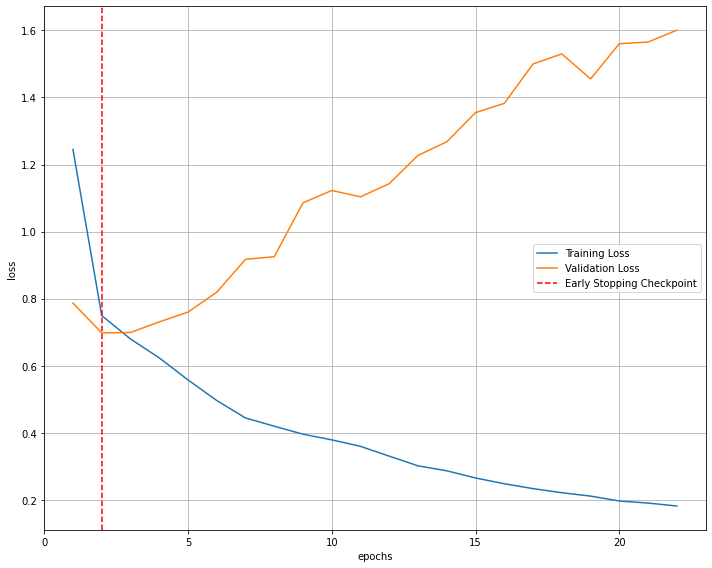

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

# 5. 테스트

#### 테스트 함수 작성

In [ ]:
# 7. 새로운 문장 테스트
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids) # forward pass: compute predicted outputs by passing inputs to the model

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("기쁨이")
            elif np.argmax(logits) == 1:
                test_eval.append("당황이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("불안이")
            elif np.argmax(logits) == 4:
                test_eval.append("상처가")
            elif np.argmax(logits) == 5:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 6:
                test_eval.append("중립이")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

####테스트 실행

In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 전 남자친구가 사준 커플 패딩을 안 버렸다고 지금 남자친구가 화났어. 내가 잘못한거 같아. 어떻게 사과해야할까?


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


>> 입력하신 내용에서 분노가 느껴집니다.




KeyboardInterrupt: ignored